# **1. Library**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler 
from pivottablejs import pivot_ui
from wordcloud import WordCloud



import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# **Config**

In [2]:
#data test
datatest = 0.25

#SVM
cost1 = [0.1, 1,10]
gamma1  = [1, 0.1, 0.01]
kernel1  = ['rbf','linear','poly','sigmoid']


#Naive Bayes
alpha1 = [0.001, 0.01, 0.1, 1, 10, 100]
params_alpha = {0.001: 'alpha = 0.001',
 0.01: 'alpha = 0.01',
 0.1: 'alpha = 0.1',
 1: 'alpha = 1',
 10: 'alpha = 10',
 100: 'alpha = 100'}

# **2. Processing Classification 50/50**

## **2.1 Classification 2.1**

In [3]:
Data21 = pd.read_csv('Data21.csv')
Data21 = Data21.dropna(subset=['content'])
y21 = Data21[['sentiment']]
Data21

,content,sentiment
0,aplikasi manfaat lokasi driver online tsb,1
1,mahal saing selamat tinggal grab terima tani t...,-1
2,aplikasi anjing gua udh paketin tpi nemu drive...,-1
3,sistem aplikasi lot,-1
4,instal ulang akses lokasi gabisa yamalah ngula...,-1
...,...,...
145,klo update dpt driver,-1
146,aplikasi grab bantu banget rumah tangga repot ...,1
147,angel angel,-1
148,knpa hrus diupdate tros memori guw pnuhh,-1


In [4]:
counter = CountVectorizer()

X = counter.fit_transform(Data21['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data21.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf.set_index(Data21.index,inplace =True)
df_tfidf21 = df_tfidf

In [5]:
X_train21, X_test21, y_train21, y_test21 = train_test_split(df_tfidf21, y21, test_size = datatest, random_state = 546)

In [6]:
X_train121, X_test121, y_train121, y_test121 = train_test_split(Data21, y21, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [7]:
start= time.time()


param_svm21 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1}

svm21 = SVC(probability=True)
grid_cv_svm21 = GridSearchCV(svm21, param_svm21, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train21, y_train21.values.ravel())

print("Param for SVM", grid_cv_svm21.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train21, grid_cv_svm21.predict(X_train21)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test21, grid_cv_svm21.predict(X_test21)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train21, grid_cv_svm21.predict(X_train21)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test21, grid_cv_svm21.predict(X_test21)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}
Train Accuracy Score for SVM:  0.9910714285714286
Test Accuracy Score for SVM:  0.5263157894736842
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      0.98      0.99        55
           1       0.98      1.00      0.99        57

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.56      0.45      0.50        20
           1       0.50      0.61      0.55        18

    accuracy                           0.53        38
   macro avg       0.53      0.53      0.53        38
weighted av

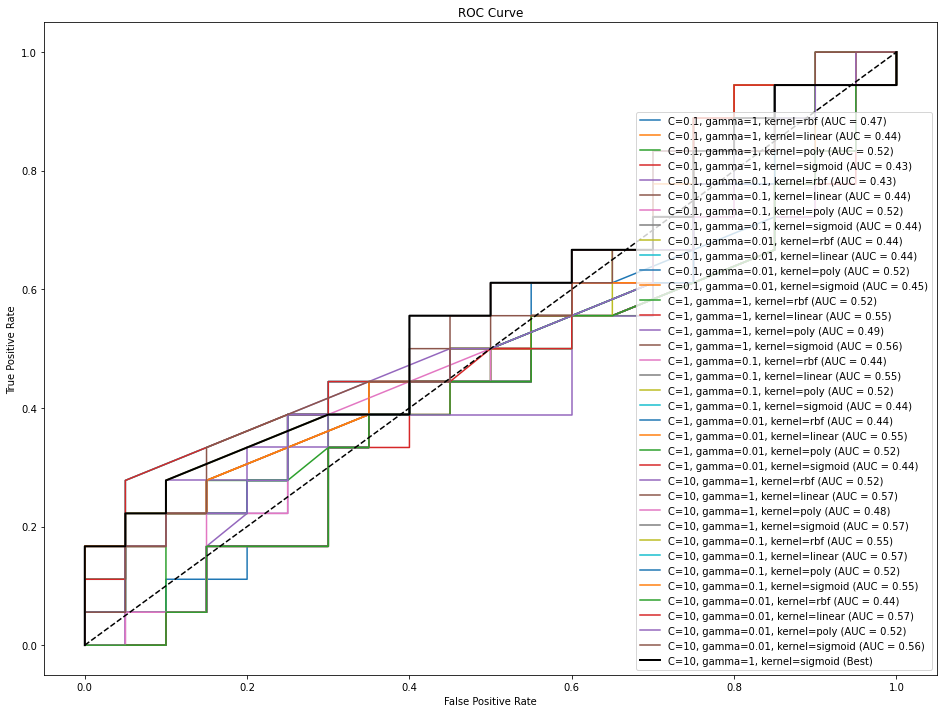

In [8]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm21['C']:
    for gamma in param_svm21['gamma']:
        for kernel in param_svm21['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train21, y_train21)
            y_pred_prob = svm.predict_proba(X_test21)[:, 1]
            fpr, tpr, _ = roc_curve(y_test21, y_pred_prob)
            roc_auc = roc_auc_score(y_test21, y_pred_prob)
           
            if roc_auc > max_auc:
                max_auc = roc_auc
            
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm21 = max_auc

**---------Naive Bayes-------------------------**

In [9]:
start = time.time()

scaler = MinMaxScaler()
X_train21nb = scaler.fit_transform(X_train21)
X_test21nb = scaler.transform(X_test21)
param_nb21 = {'alpha': alpha1}

nb21 = MultinomialNB()
grid_cv_nb21 = GridSearchCV(nb21, param_nb21, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train21nb, y_train21.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb21.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train21, grid_cv_nb21.predict(X_train21nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test21, grid_cv_nb21.predict(X_test21nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train21, grid_cv_nb21.predict(X_train21nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test21, grid_cv_nb21.predict(X_test21nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 0.001}
Train accuracy score for Naive Bayes: 1.0
Test accuracy score for Naive Bayes: 0.5789473684210527
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        57

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.59      0.65      0.62        20
           1       0.56      0.50      0.53        18

    accuracy                           0.58        38
   macro avg       0.58      0.57      0.57        38
weight

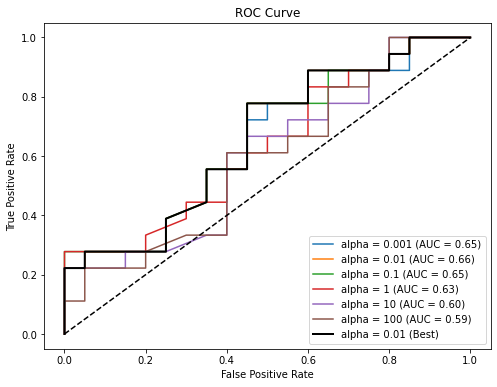

In [10]:
params = params_alpha 

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train21nb, y_train21)
    y_prob = nb.predict_proba(X_test21nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test21, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc

    if roc_auc > max_auc:
        max_auc = roc_auc
    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb21 = max_auc

**------------Running Best Parameters---------------**

In [11]:
start = time.time()


svm = SVC(C=grid_cv_svm21.best_params_['C'],
          gamma=grid_cv_svm21.best_params_['gamma'],
          kernel=grid_cv_svm21.best_params_['kernel'])

svm.fit(X_train21, y_train21)
y_test_svm21 = svm.predict(X_test21)

svm_results21 = pd.DataFrame({'True Labels': y_test21.values.ravel(),
                               'Predicted Labels': y_test_svm21})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.04 seconds


In [12]:
start = time.time()

nb = MultinomialNB(alpha=grid_cv_nb21.best_params_['alpha'])
nb.fit(X_train21nb, y_train21)
y_test_nb21 = nb.predict(X_test21nb)

nb_results21 = pd.DataFrame({'True Labels': y_test21.values.ravel(),
                               'Predicted Labels': y_test_nb21})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.01 seconds


**Comparation Performance Result**

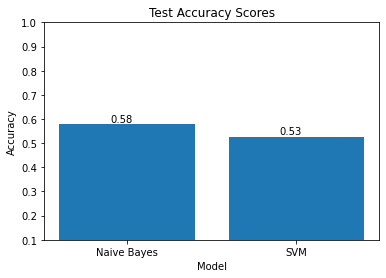

In [13]:
nb_test_acc21 = accuracy_score(y_test21,y_test_nb21)
svm_test_acc21 = accuracy_score(y_test21, y_test_svm21)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc21, svm_test_acc21])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc21 + 0.01, '{:.2f}'.format(nb_test_acc21))
plt.text(0.9, svm_test_acc21 + 0.01, '{:.2f}'.format(svm_test_acc21))
plt.show()


In [14]:
result_svm21 = pd.merge(X_test121[['content']], svm_results21[['Predicted Labels']], left_index=True, right_index=True)
result_nb21 = pd.merge(X_test121[['content']], nb_results21[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [15]:
positive_words = []
negative_words = []
for _, row in result_nb21.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,grab,4,kadang,1.0
1,gampang,2,suka,1.0
2,akun,2,error,1.0
3,food,2,overall,1.0
4,download,1,bantu,1.0
5,trs,1,NaN,NaN
6,eroor,1,NaN,NaN
7,tulis,1,NaN,NaN
8,muncul,1,NaN,NaN
9,yg,1,NaN,NaN


**--------Result From SVM------------**

In [16]:
positive_words = []
negative_words = []
for _, row in result_svm21.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,grab,4,NaN,NaN
1,gampang,2,NaN,NaN
2,akun,2,NaN,NaN
3,food,2,NaN,NaN
4,eroor,1,NaN,NaN
5,tulis,1,NaN,NaN
6,muncul,1,NaN,NaN
7,yg,1,NaN,NaN
8,daftar,1,NaN,NaN
9,butuh,1,NaN,NaN


## **2.2 Classification 2.2**

In [17]:
Data22 = pd.read_csv('Data22.csv')
Data22 = Data22.dropna(subset=['content'])
y22 = Data22[['sentiment']]

In [18]:
counter = CountVectorizer()

X = counter.fit_transform(Data22['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data22.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf22 = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf22.set_index(Data22.index,inplace =True)
df_tfidf22  


,abis,adalah,admin,ae,agar,aidzin,ajaa,aju,akhir,akses,...,yaa,yah,yahjd,yamalah,yaman,yang,yeayy,yelah,yl,yummi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436586,...,0.0,0.0,0.0,0.218293,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.211441,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [19]:
X_train22, X_test22, y_train22, y_test22 = train_test_split(df_tfidf22, y22, test_size = datatest, random_state = 546)

In [20]:
X_train122, X_test122, y_train122, y_test122 = train_test_split(Data22, y22, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [21]:
start= time.time()
param_svm22 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1}

svm22 = SVC(probability=True)
grid_cv_svm22 = GridSearchCV(svm22, param_svm22, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train22, y_train22.values.ravel())

print("Param for SVM", grid_cv_svm22.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train22, grid_cv_svm22.predict(X_train22)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test22, grid_cv_svm22.predict(X_test22)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train22, grid_cv_svm22.predict(X_train22)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test22, grid_cv_svm22.predict(X_test22)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Train Accuracy Score for SVM:  1.0
Test Accuracy Score for SVM:  0.631578947368421
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        57

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.65      0.65      0.65        20
           1       0.61      0.61      0.61        18

    accuracy                           0.63        38
   macro avg       0.63      0.63      0.63        38
weighted avg       0.63      0

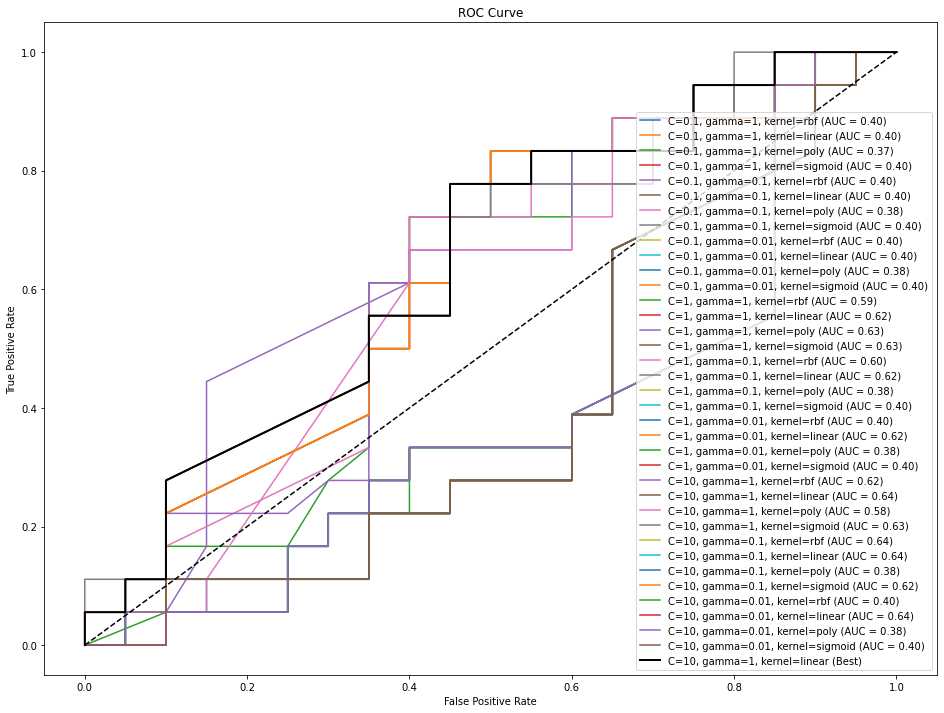

In [22]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm22['C']:
    for gamma in param_svm22['gamma']:
        for kernel in param_svm22['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train22, y_train22)
            y_pred_prob = svm.predict_proba(X_test22)[:, 1]
            fpr, tpr, _ = roc_curve(y_test22, y_pred_prob)
            roc_auc = roc_auc_score(y_test22, y_pred_prob)
                       
            if roc_auc > max_auc :
                max_auc = roc_auc
                
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm22 = max_auc

**---------Naive Bayes-------------------------**

In [23]:
start = time.time()

scaler = MinMaxScaler()
X_train22nb = scaler.fit_transform(X_train22)
X_test22nb = scaler.transform(X_test22)
param_nb22 = {'alpha': alpha1}

nb22 = MultinomialNB()
grid_cv_nb22 = GridSearchCV(nb22, param_nb22, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train22nb, y_train22.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb22.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train22, grid_cv_nb22.predict(X_train22nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test22, grid_cv_nb22.predict(X_test22nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train22, grid_cv_nb22.predict(X_train22nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test22, grid_cv_nb22.predict(X_test22nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 0.001}
Train accuracy score for Naive Bayes: 1.0
Test accuracy score for Naive Bayes: 0.5526315789473685
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        57

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.57      0.60      0.59        20
           1       0.53      0.50      0.51        18

    accuracy                           0.55        38
   macro avg       0.55      0.55      0.55        38
weight

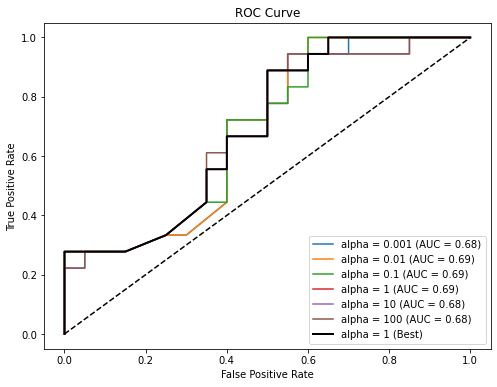

In [24]:
params = params_alpha
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train22nb, y_train22)
    y_prob = nb.predict_proba(X_test22nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test22, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc    
    if roc_auc > max_auc:
        max_auc = roc_auc

    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb22 = max_auc

**------------Running Best Parameters---------------**

In [25]:
start = time.time()


svm = SVC(C=grid_cv_svm22.best_params_['C'],
          gamma=grid_cv_svm22.best_params_['gamma'],
          kernel=grid_cv_svm22.best_params_['kernel'])

svm.fit(X_train22, y_train22)
y_test_svm22 = svm.predict(X_test22)

svm_results22 = pd.DataFrame({'True Labels': y_test22.values.ravel(),
                               'Predicted Labels': y_test_svm22})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.04 seconds


In [26]:
start = time.time()


nb = MultinomialNB(alpha=grid_cv_nb22.best_params_['alpha'])
nb.fit(X_train22nb, y_train22)
y_test_nb22 = nb.predict(X_test22nb)

nb_results22 = pd.DataFrame({'True Labels': y_test22.values.ravel(),
                               'Predicted Labels': y_test_nb22})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.01 seconds


**Comparation Performance Result**

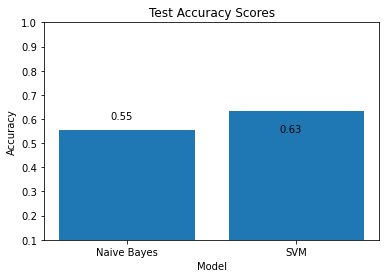

In [27]:
nb_test_acc22 = accuracy_score(y_test22,y_test_nb22)
svm_test_acc22 = accuracy_score(y_test22, grid_cv_svm22.predict(X_test22))
#grid_cv_nb22.predict(X_test22)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc22, svm_test_acc22])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc21 +0.02, '{:.2f}'.format(nb_test_acc22))
plt.text(0.9, svm_test_acc21 +0.02, '{:.2f}'.format(svm_test_acc22))
plt.show()


In [28]:
result_svm22 = pd.merge(X_test122[['content']], svm_results22[['Predicted Labels']], left_index=True, right_index=True)
result_nb22 = pd.merge(X_test122[['content']], nb_results22[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [29]:
positive_words = []
negative_words = []
for _, row in result_nb22.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,akun,2,food,2
1,bnget,1,dengan,1
2,gimana,1,jd,1
3,trs,1,gampang,1
4,eroor,1,malam,1
5,tulis,1,hujan,1
6,cuma,1,ngak,1
7,muncul,1,henti,1
8,baru,1,untung,1
9,daftar,1,saja,1


**--------Result From SVM------------**

In [30]:
positive_words = []
negative_words = []
for _, row in result_svm22.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,akun,2,food,2
1,bnget,1,dengan,1
2,gimana,1,jd,1
3,trs,1,gampang,1
4,eroor,1,malam,1
5,tulis,1,hujan,1
6,cuma,1,ngak,1
7,muncul,1,henti,1
8,baru,1,untung,1
9,daftar,1,saja,1


## **2.3 Classification 2.3**

In [31]:
Data23 = pd.read_csv('Data23.csv')
Data23 = Data23.dropna(subset=['content'])
y23 = Data23[['sentiment']]

In [32]:
counter = CountVectorizer()

X = counter.fit_transform(Data23['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data23.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf23 = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf23.set_index(Data23.index,inplace =True)
df_tfidf23

,abis,admin,ae,aidzin,ajaa,aju,akses,akun,akurat,alamat,...,wkwk,xlipat,yahjd,yam,yama,ye,yeayy,yg,yl,yummi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.566344,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.283172,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [33]:
X_train23, X_test23, y_train23, y_test23 = train_test_split(df_tfidf23, y23, test_size = datatest, random_state = 546)

In [34]:
X_train123, X_test123, y_train123, y_test123 = train_test_split(Data23, y23, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [35]:
start= time.time()
param_svm23 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1}

svm23 = SVC(probability=True)
grid_cv_svm23 = GridSearchCV(svm23, param_svm23, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train23, y_train23.values.ravel())

print("Param for SVM", grid_cv_svm23.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train23, grid_cv_svm23.predict(X_train23)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test23, grid_cv_svm23.predict(X_test23)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train23, grid_cv_svm23.predict(X_train23)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test23, grid_cv_svm23.predict(X_test23)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy Score for SVM:  1.0
Test Accuracy Score for SVM:  0.5789473684210527
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        57

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.60      0.60      0.60        20
           1       0.56      0.56      0.56        18

    accuracy                           0.58        38
   macro avg       0.58      0.58      0.58        38
weighted avg       0.58   

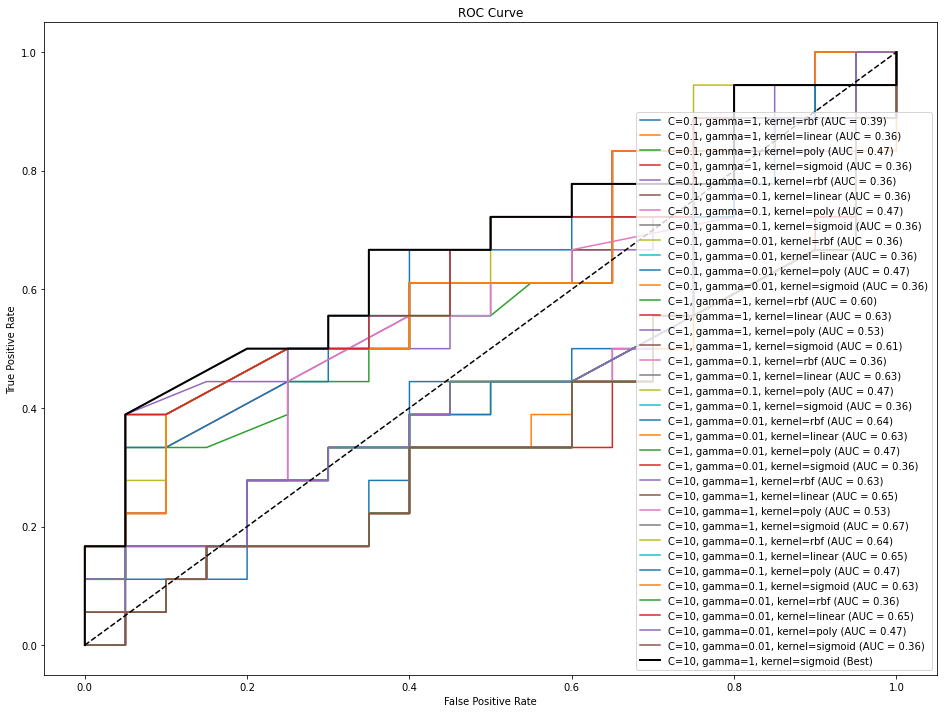

In [36]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm23['C']:
    for gamma in param_svm23['gamma']:
        for kernel in param_svm23['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train23, y_train23)
            y_pred_prob = svm.predict_proba(X_test23)[:, 1]
            fpr, tpr, _ = roc_curve(y_test23, y_pred_prob)
            roc_auc = roc_auc_score(y_test23, y_pred_prob)
                       
            if roc_auc > max_auc:
                max_auc = roc_auc
                
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm23 = max_auc

**--------------Naive Bayes----------**

In [37]:
start = time.time()

scaler = MinMaxScaler()
X_train23nb = scaler.fit_transform(X_train23)
X_test23nb = scaler.transform(X_test23)
param_nb23 = {'alpha': alpha1}

nb23 = MultinomialNB()
grid_cv_nb23 = GridSearchCV(nb23, param_nb23, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train23nb, y_train23.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb23.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train23, grid_cv_nb23.predict(X_train23nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test23, grid_cv_nb23.predict(X_test23nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train23, grid_cv_nb23.predict(X_train23nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test23, grid_cv_nb23.predict(X_test23nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 0.01}
Train accuracy score for Naive Bayes: 1.0
Test accuracy score for Naive Bayes: 0.5789473684210527
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        57

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.59      0.65      0.62        20
           1       0.56      0.50      0.53        18

    accuracy                           0.58        38
   macro avg       0.58      0.57      0.57        38
weighte

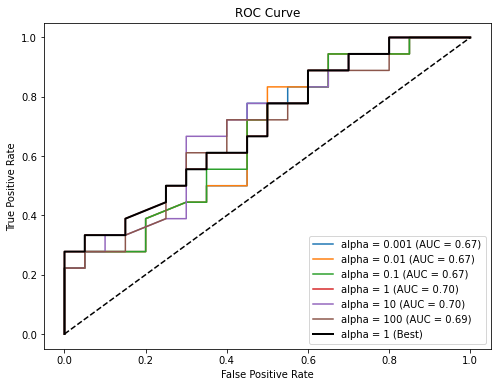

In [38]:
params =params_alpha

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train23nb, y_train23)
    y_prob = nb.predict_proba(X_test23nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test23, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc    
    if roc_auc > max_auc:
        max_auc = roc_auc

    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb23 = max_auc

**------------Running Best Parameters---------------**

In [39]:
start = time.time()


svm = SVC(C=grid_cv_svm23.best_params_['C'],
          gamma=grid_cv_svm23.best_params_['gamma'],
          kernel=grid_cv_svm23.best_params_['kernel'])

svm.fit(X_train23, y_train23)
y_test_svm23 = svm.predict(X_test23)

svm_results23 = pd.DataFrame({'True Labels': y_test23.values.ravel(),
                               'Predicted Labels': y_test_svm23})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.04 seconds


In [40]:
start = time.time()

scaler = MinMaxScaler()
X_train23 = scaler.fit_transform(X_train23)
X_test23 = scaler.transform(X_test23)

nb = MultinomialNB(alpha=grid_cv_nb23.best_params_['alpha'])
nb.fit(X_train23nb, y_train23)
y_test_nb23 = nb.predict(X_test23nb)

nb_results23 = pd.DataFrame({'True Labels': y_test23.values.ravel(),
                               'Predicted Labels': y_test_nb23})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.04 seconds


**Comparation Performance Result**

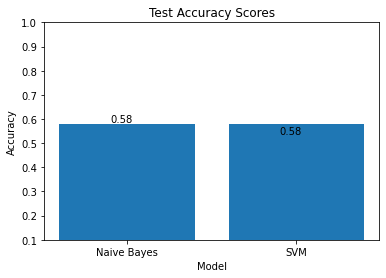

In [41]:
nb_test_acc23 = accuracy_score(y_test23,y_test_nb23)
svm_test_acc23 = accuracy_score(y_test23, y_test_svm23)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc23, svm_test_acc23])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc21 + 0.01, '{:.2f}'.format(nb_test_acc23))
plt.text(0.9, svm_test_acc21 + 0.01, '{:.2f}'.format(svm_test_acc23))
plt.show()


In [42]:
result_svm23 = pd.merge(X_test123[['content']], svm_results23[['Predicted Labels']], left_index=True, right_index=True)
result_nb23 = pd.merge(X_test123[['content']], nb_results23[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [43]:
positive_words = []
negative_words = []
for _, row in result_nb23.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,akun,2,grab,3
1,keren,1,food,2
2,bnget,1,jd,1
3,trs,1,gampang,1
4,eroor,1,malam,1
5,tulis,1,hujan,1
6,muncul,1,henti,1
7,yg,1,untung,1
8,daftar,1,tq,1
9,sekali,1,bang,1


**--------Result From SVM------------**

In [44]:
positive_words = []
negative_words = []
for _, row in result_svm23.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,akun,2,grab,3
1,keren,1,food,2
2,bnget,1,jd,1
3,trs,1,gampang,1
4,eroor,1,malam,1
5,tulis,1,hujan,1
6,muncul,1,henti,1
7,yg,1,untung,1
8,daftar,1,tq,1
9,sekali,1,bang,1


## **2.4 Classification 2.4**

In [45]:
Data24 = pd.read_csv('Data24.csv')
Data24 = Data24.dropna(subset=['content'])
y24 = Data24[['sentiment']]

In [46]:
counter = CountVectorizer()

X = counter.fit_transform(Data24['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data24.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf24 = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf24.set_index(Data24.index,inplace =True)
df_tfidf24

,abis,adalah,admin,ae,agar,aidzin,ajaa,aju,akhir,akses,...,yaa,yah,yahjd,yam,yama,yang,ye,yeayy,yl,yummi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.43914,...,0.0,0.0,0.0,0.0,0.21957,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.209638,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0


In [47]:
X_train24, X_test24, y_train24, y_test24 = train_test_split(df_tfidf24, y24, test_size = datatest, random_state = 546)

In [48]:
X_train124, X_test124, y_train124, y_test124 = train_test_split(Data24, y24, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [49]:
start= time.time()
param_svm24 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1
            }

svm24 = SVC(probability=True)
grid_cv_svm24 = GridSearchCV(svm24, param_svm24, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train24, y_train24.values.ravel())

print("Param for SVM", grid_cv_svm24.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train24, grid_cv_svm24.predict(X_train24)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test24, grid_cv_svm24.predict(X_test24)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train24, grid_cv_svm24.predict(X_train24)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test24, grid_cv_svm24.predict(X_test24)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy Score for SVM:  1.0
Test Accuracy Score for SVM:  0.6052631578947368
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        57

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.63      0.60      0.62        20
           1       0.58      0.61      0.59        18

    accuracy                           0.61        38
   macro avg       0.61      0.61      0.60        38
weighted avg       0.61    

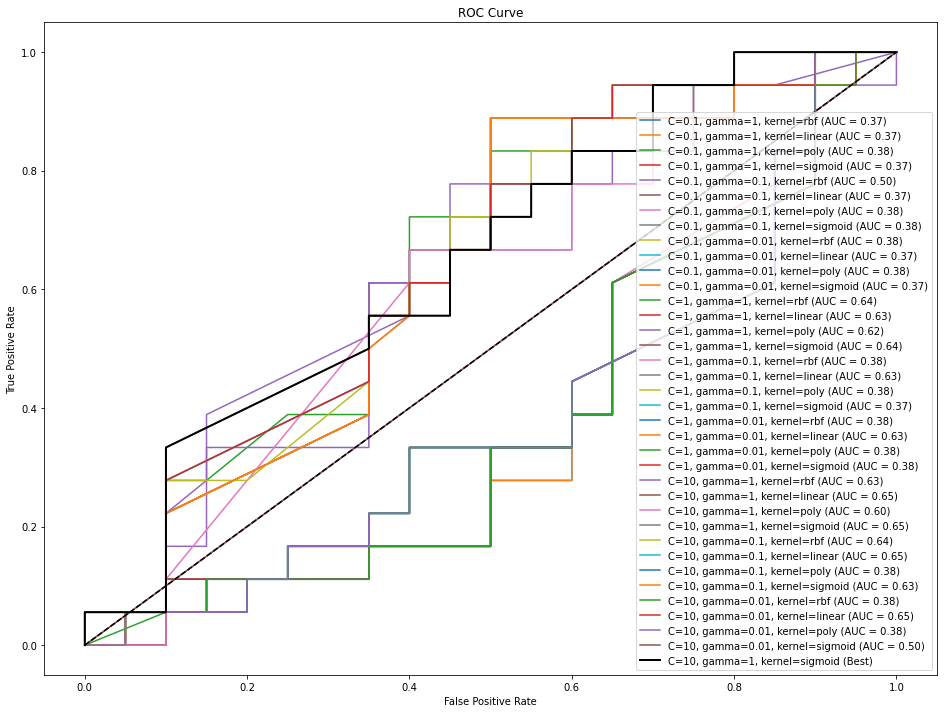

In [50]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm24['C']:
    for gamma in param_svm24['gamma']:
        for kernel in param_svm24['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train24, y_train24)
            y_pred_prob = svm.predict_proba(X_test24)[:, 1]
            fpr, tpr, _ = roc_curve(y_test24, y_pred_prob)
            roc_auc = roc_auc_score(y_test24, y_pred_prob)
            if roc_auc > max_auc:
                max_auc = roc_auc
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm24= max_auc

**---------Naive Bayes-------------------------**

In [51]:
start = time.time()

scaler = MinMaxScaler()
X_train24nb = scaler.fit_transform(X_train24)
X_test24nb = scaler.transform(X_test24)
param_nb24 = {'alpha': alpha1}

nb24 = MultinomialNB()
grid_cv_nb24 = GridSearchCV(nb24, param_nb24, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train24nb, y_train24.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb24.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train24, grid_cv_nb24.predict(X_train24nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test24, grid_cv_nb24.predict(X_test24nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train24, grid_cv_nb24.predict(X_train24nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test24, grid_cv_nb24.predict(X_test24nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 0.001}
Train accuracy score for Naive Bayes: 1.0
Test accuracy score for Naive Bayes: 0.5526315789473685
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        57

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.57      0.60      0.59        20
           1       0.53      0.50      0.51        18

    accuracy                           0.55        38
   macro avg       0.55      0.55      0.55        38
weight

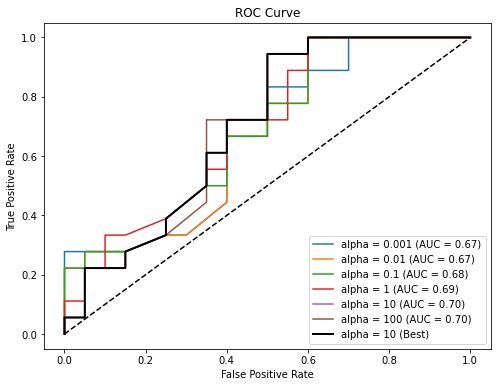

In [52]:
params = params_alpha

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train24nb, y_train24)
    y_prob = nb.predict_proba(X_test24nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test24, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc    
    if roc_auc > max_auc:
        max_auc = roc_auc

    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb24 = max_auc

**------------Running Best Parameters---------------**

In [53]:
start = time.time()


svm = SVC(C=grid_cv_svm24.best_params_['C'],
          gamma=grid_cv_svm24.best_params_['gamma'],
          kernel=grid_cv_svm24.best_params_['kernel'])

svm.fit(X_train24, y_train24)
y_test_svm24 = svm.predict(X_test24)

svm_results24 = pd.DataFrame({'True Labels': y_test24.values.ravel(),
                               'Predicted Labels': y_test_svm24})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.04 seconds


In [54]:
start = time.time()



nb = MultinomialNB(alpha=grid_cv_nb24.best_params_['alpha'])
nb.fit(X_train24nb, y_train24)
y_test_nb24 = nb.predict(X_test24nb)

nb_results24 = pd.DataFrame({'True Labels': y_test24.values.ravel(),
                               'Predicted Labels': y_test_nb24})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.01 seconds


**Comparation Performance Result**

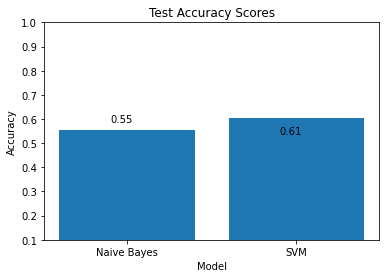

In [55]:
nb_test_acc24 = accuracy_score(y_test24,y_test_nb24)
svm_test_acc24 = accuracy_score(y_test24, y_test_svm24)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc24, svm_test_acc24])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc21 + 0.01, '{:.2f}'.format(nb_test_acc24))
plt.text(0.9, svm_test_acc21 + 0.01, '{:.2f}'.format(svm_test_acc24))
plt.show()


In [56]:
result_svm24 = pd.merge(X_test124[['content']], svm_results24[['Predicted Labels']], left_index=True, right_index=True)
result_nb24 = pd.merge(X_test124[['content']], nb_results24[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [57]:
positive_words = []
negative_words = []
for _, row in result_nb24.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,akun,2,food,2
1,bnget,1,dengan,1
2,gimana,1,jd,1
3,trs,1,gampang,1
4,eroor,1,malam,1
5,tulis,1,hujan,1
6,cuma,1,ngak,1
7,muncul,1,henti,1
8,baru,1,untung,1
9,daftar,1,saja,1


**--------Result From SVM------------**

In [58]:
positive_words = []
negative_words = []
for _, row in result_svm24.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,akun,2,food,2
1,bnget,1,dengan,1
2,gimana,1,jd,1
3,trs,1,gampang,1
4,eroor,1,malam,1
5,tulis,1,hujan,1
6,cuma,1,ngak,1
7,muncul,1,henti,1
8,baru,1,untung,1
9,daftar,1,saja,1


# **3. Processing Classification 70/30**

## **3.1 Classification 3.1**

In [59]:
Data31 = pd.read_csv('Data31.csv')
Data31 = Data31.dropna(subset=['content'])
y31 = Data31[['sentiment']]

In [60]:
counter = CountVectorizer()

X = counter.fit_transform(Data31['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data31.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf31 = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf31.set_index(Data31.index,inplace =True)
df_tfidf31

,aaplikasi,adminknp,aktifitas,aktivitas,akun,alam,alfamart,alhamdulillah,allah,amsyong,...,untung,update,updatenya,verifikasi,verivikasi,vermuk,weeeewww,yaman,yess,yg
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.28865,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
X_train31, X_test31, y_train31, y_test31 = train_test_split(df_tfidf31, y31, test_size = datatest, random_state = 546)

In [62]:
X_train131, X_test131, y_train131, y_test131 = train_test_split(Data31, y31, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [63]:
start= time.time()
param_svm31 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1
            }

svm31 = SVC(probability=True)
grid_cv_svm31 = GridSearchCV(svm31, param_svm31, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train31, y_train31.values.ravel())

print("Param for SVM", grid_cv_svm31.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train31, grid_cv_svm31.predict(X_train31)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test31, grid_cv_svm31.predict(X_test31)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train31, grid_cv_svm31.predict(X_train31)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test31, grid_cv_svm31.predict(X_test31)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}
Train Accuracy Score for SVM:  1.0
Test Accuracy Score for SVM:  0.7368421052631579
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        76

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.29      0.29      0.29         7
           1       0.84      0.84      0.84        31

    accuracy                           0.74        38
   macro avg       0.56      0.56      0.56        38
weighted avg       0.74  

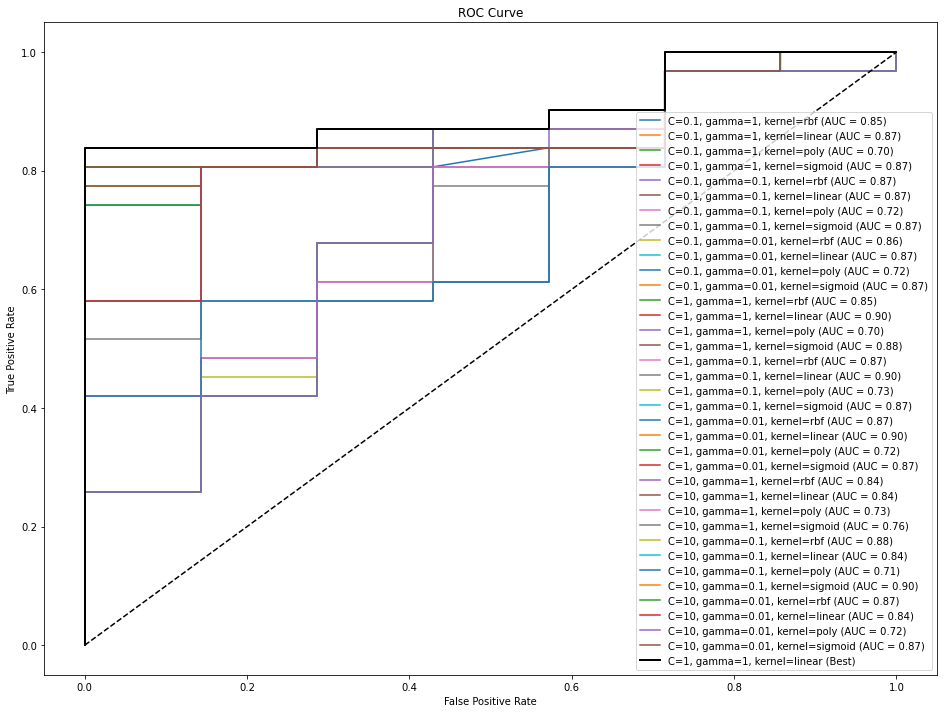

In [64]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm31['C']:
    for gamma in param_svm31['gamma']:
        for kernel in param_svm31['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train31, y_train31)
            y_pred_prob = svm.predict_proba(X_test31)[:, 1]
            fpr, tpr, _ = roc_curve(y_test31, y_pred_prob)
            roc_auc = roc_auc_score(y_test31, y_pred_prob)
            
            if roc_auc > max_auc:
                max_auc = roc_auc
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm31 = max_auc

**---------Naive Bayes-------------------------**

In [65]:
start = time.time()

scaler = MinMaxScaler()
X_train31nb = scaler.fit_transform(X_train31)
X_test31nb = scaler.transform(X_test31)
param_nb31 = {'alpha': alpha1}

nb31 = MultinomialNB()
grid_cv_nb31 = GridSearchCV(nb31, param_nb31, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train31nb, y_train31.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb31.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train31, grid_cv_nb31.predict(X_train31nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test31, grid_cv_nb31.predict(X_test31nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train31, grid_cv_nb31.predict(X_train31nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test31, grid_cv_nb31.predict(X_test31nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 0.1}
Train accuracy score for Naive Bayes: 1.0
Test accuracy score for Naive Bayes: 0.7631578947368421
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        76

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.42      0.71      0.53         7
           1       0.92      0.77      0.84        31

    accuracy                           0.76        38
   macro avg       0.67      0.74      0.68        38
weighted

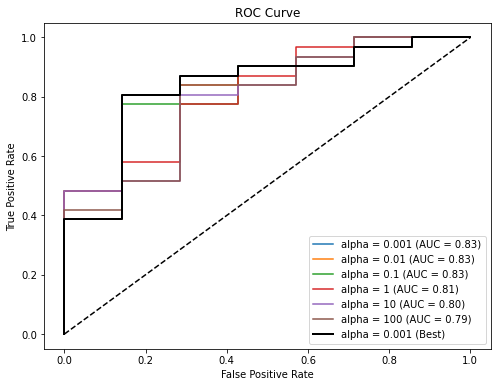

In [66]:
params = params_alpha

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train31nb, y_train31)
    y_prob = nb.predict_proba(X_test31nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test31, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc   
    if roc_auc > max_auc:
        max_auc = roc_auc

    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb31 = max_auc

**------------Running Best Parameters---------------**

In [67]:
start = time.time()


svm = SVC(C=grid_cv_svm31.best_params_['C'],
          gamma=grid_cv_svm31.best_params_['gamma'],
          kernel=grid_cv_svm31.best_params_['kernel'])

svm.fit(X_train31, y_train31)
y_test_svm31 = svm.predict(X_test31)

svm_results31 = pd.DataFrame({'True Labels': y_test31.values.ravel(),
                               'Predicted Labels': y_test_svm31})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.03 seconds


In [68]:
start = time.time()



nb31 = MultinomialNB(alpha=grid_cv_nb31.best_params_['alpha'])
nb31.fit(X_train31nb, y_train31)
y_test_nb31 = nb31.predict(X_test31nb)

nb_results31 = pd.DataFrame({'True Labels': y_test31.values.ravel(),
                               'Predicted Labels': y_test_nb31})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.01 seconds


**Comparation Performance Result**

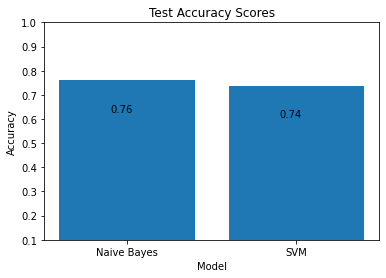

In [69]:
nb_test_acc31 = accuracy_score(y_test31,y_test_nb31)
svm_test_acc31 = accuracy_score(y_test31, y_test_svm31)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc31, svm_test_acc31])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc21 + 0.05, '{:.2f}'.format(nb_test_acc31))
plt.text(0.9, svm_test_acc21 + 0.08, '{:.2f}'.format(svm_test_acc31))
plt.show()


In [70]:
result_svm31 = pd.merge(X_test131[['content']], svm_results31[['Predicted Labels']], left_index=True, right_index=True)
result_nb31 = pd.merge(X_test131[['content']], nb_results31[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [71]:
positive_words = []
negative_words = []
for _, row in result_nb31.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,bantu,2,NaN,NaN
1,aplikasi,1,NaN,NaN
2,oke,1,NaN,NaN
3,sanggat,1,NaN,NaN
4,moga,1,NaN,NaN
5,grab,1,NaN,NaN
6,nyaman,1,NaN,NaN
7,depan,1,NaN,NaN
8,good,1,NaN,NaN
9,job,1,NaN,NaN


**--------Result From SVM------------**

In [72]:
positive_words = []
negative_words = []
for _, row in result_svm31.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,bantu,2,NaN,NaN
1,aplikasi,1,NaN,NaN
2,oke,1,NaN,NaN
3,sanggat,1,NaN,NaN
4,moga,1,NaN,NaN
5,grab,1,NaN,NaN
6,nyaman,1,NaN,NaN
7,depan,1,NaN,NaN
8,good,1,NaN,NaN
9,job,1,NaN,NaN


## **3.2 Classification 3.2**

In [73]:
Data32 = pd.read_csv('Data32.csv')
Data32 = Data32.dropna(subset=['content'])
y32 = Data32[['sentiment']]

In [74]:
counter = CountVectorizer()

X = counter.fit_transform(Data32['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data32.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf32 = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf32.set_index(Data32.index,inplace =True)
df_tfidf32

,aaplikasi,ada,adminknp,aduh,agak,aj,aja,akhir,aktifitas,aktivitas,...,utk,verifikasi,verivikasi,vermuk,waktu,weeeewww,yaa,yaman,yang,yess
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.309131,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.637711,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X_train32, X_test32, y_train32, y_test32 = train_test_split(df_tfidf32, y32, test_size = datatest, random_state = 546)

In [76]:
X_train132, X_test132, y_train132, y_test132 = train_test_split(Data32, y32, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [77]:
start= time.time()
param_svm32 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1
            }

svm32 = SVC(probability=True)
grid_cv_svm32 = GridSearchCV(svm32, param_svm32, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train32, y_train32.values.ravel())

print("Param for SVM", grid_cv_svm32.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train32, grid_cv_svm32.predict(X_train32)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test32, grid_cv_svm32.predict(X_test32)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train32, grid_cv_svm32.predict(X_train32)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test32, grid_cv_svm32.predict(X_test32)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy Score for SVM:  1.0
Test Accuracy Score for SVM:  0.8421052631578947
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        77

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.67      0.29      0.40         7
           1       0.86      0.97      0.91        31

    accuracy                           0.84        38
   macro avg       0.76      0.63      0.65        38
weighted avg       0.82   

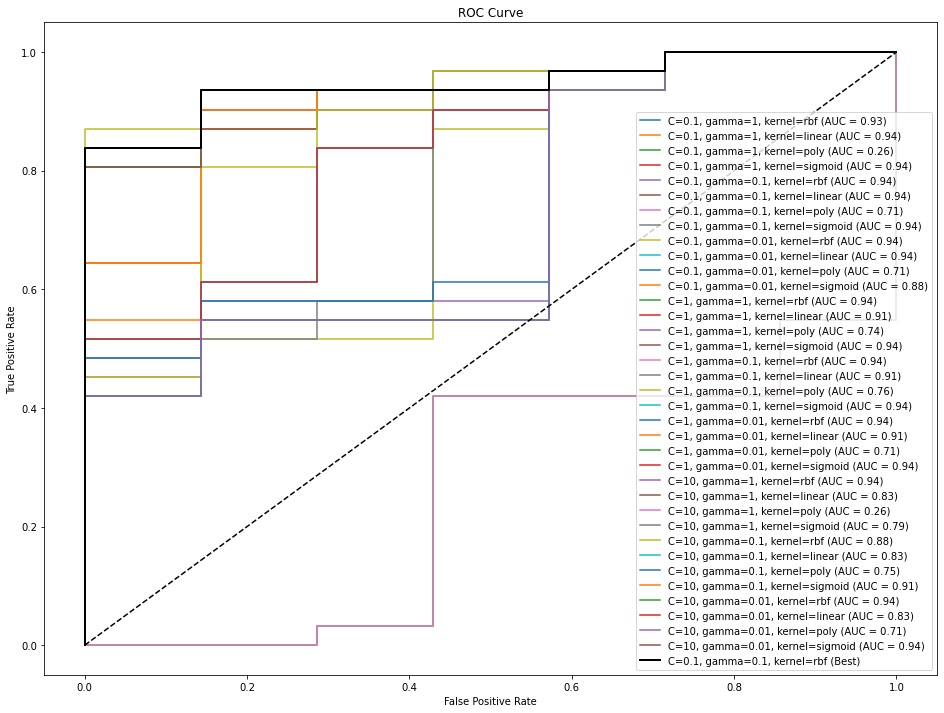

In [78]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm32['C']:
    for gamma in param_svm32['gamma']:
        for kernel in param_svm32['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train32, y_train32)
            y_pred_prob = svm.predict_proba(X_test32)[:, 1]
            fpr, tpr, _ = roc_curve(y_test32, y_pred_prob)
            roc_auc = roc_auc_score(y_test32, y_pred_prob)
            if roc_auc > max_auc:
                max_auc = roc_auc
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm32 = max_auc

**---------Naive Bayes-------------------------**

In [79]:
start = time.time()

scaler = MinMaxScaler()
X_train32nb = scaler.fit_transform(X_train32)
X_test32nb = scaler.transform(X_test32)
param_nb32 = {'alpha': alpha1}

nb32 = MultinomialNB()
grid_cv_nb32 = GridSearchCV(nb32, param_nb32, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train32nb, y_train32.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb32.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train32, grid_cv_nb32.predict(X_train32nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test32, grid_cv_nb32.predict(X_test32nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train32, grid_cv_nb32.predict(X_train32nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test32, grid_cv_nb32.predict(X_test32nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 1}
Train accuracy score for Naive Bayes: 1.0
Test accuracy score for Naive Bayes: 0.7894736842105263
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        77

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.44      0.57      0.50         7
           1       0.90      0.84      0.87        31

    accuracy                           0.79        38
   macro avg       0.67      0.71      0.68        38
weighted a

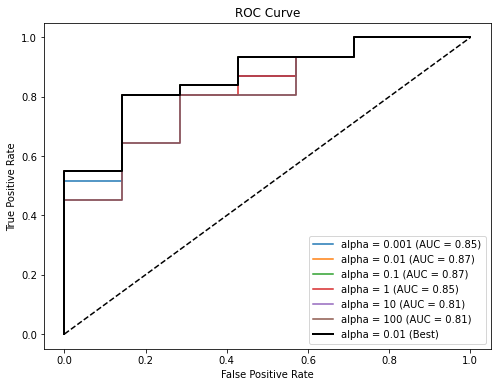

In [80]:
params =params_alpha

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train32nb, y_train32)
    y_prob = nb.predict_proba(X_test32nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test32, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc    
    if roc_auc > max_auc:
        max_auc = roc_auc

    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb32 = max_auc

**------------Running Best Parameters---------------**

In [81]:
start = time.time()


svm = SVC(C=grid_cv_svm32.best_params_['C'],
          gamma=grid_cv_svm32.best_params_['gamma'],
          kernel=grid_cv_svm32.best_params_['kernel'])

svm.fit(X_train32, y_train32)
y_test_svm32 = svm.predict(X_test32)

svm_results32 = pd.DataFrame({'True Labels': y_test32.values.ravel(),
                               'Predicted Labels': y_test_svm32})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.04 seconds


In [82]:
start = time.time()


nb = MultinomialNB(alpha=grid_cv_nb32.best_params_['alpha'])
nb.fit(X_train32nb, y_train32)
y_test_nb32 = nb.predict(X_test32nb)

nb_results32 = pd.DataFrame({'True Labels': y_test32.values.ravel(),
                               'Predicted Labels': y_test_nb32})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.00 seconds


**Comparation Performance Result**

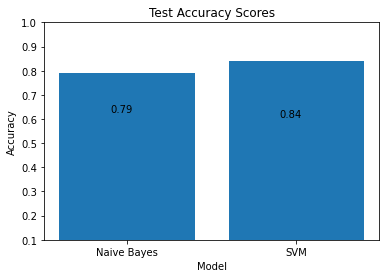

In [83]:
nb_test_acc32 = accuracy_score(y_test32,y_test_nb32)
svm_test_acc32 = accuracy_score(y_test32, y_test_svm32)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc32, svm_test_acc32])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc21 + 0.05, '{:.2f}'.format(nb_test_acc32))
plt.text(0.9, svm_test_acc21 + 0.08, '{:.2f}'.format(svm_test_acc32))
plt.show()


In [84]:
result_svm32 = pd.merge(X_test132[['content']], svm_results32[['Predicted Labels']], left_index=True, right_index=True)
result_nb32 = pd.merge(X_test132[['content']], nb_results32[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [85]:
positive_words = []
negative_words = []
for _, row in result_nb32.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,luar,1,oke,1.0
1,biasa,1,sanggat,1.0
2,karena,1,NaN,NaN
3,moga,1,NaN,NaN
4,saja,1,NaN,NaN
5,lebih,1,NaN,NaN
6,baik,1,NaN,NaN
7,nyaman,1,NaN,NaN
8,depan,1,NaN,NaN
9,good,1,NaN,NaN


**--------Result From SVM------------**

In [86]:
positive_words = []
negative_words = []
for _, row in result_svm32.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,luar,1,oke,1.0
1,biasa,1,sanggat,1.0
2,karena,1,NaN,NaN
3,moga,1,NaN,NaN
4,saja,1,NaN,NaN
5,lebih,1,NaN,NaN
6,baik,1,NaN,NaN
7,nyaman,1,NaN,NaN
8,depan,1,NaN,NaN
9,good,1,NaN,NaN


## **3.3 Classification 3.3**

In [87]:
Data33 = pd.read_csv('Data33.csv')
Data33 = Data33.dropna(subset=['content'])
y33 = Data33[['sentiment']]

In [88]:
counter = CountVectorizer()

X = counter.fit_transform(Data33['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data33.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf33 = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf33.set_index(Data33.index,inplace =True)
df_tfidf33

,aaplikasi,adminknp,aktifitas,aktivitas,akun,alam,alfamart,alhamdulillah,allah,amsyong,...,update,upgrade,urun,verifikasi,verivikasi,vermuk,weeeewww,yam,yess,yg
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.288768,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
X_train33, X_test33, y_train33, y_test33 = train_test_split(df_tfidf33, y33, test_size = datatest, random_state = 546)

In [90]:
X_train133, X_test133, y_train133, y_test133 = train_test_split(Data33, y33, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [91]:
start= time.time()
param_svm33 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1
            }

svm33 = SVC(probability=True)
grid_cv_svm33 = GridSearchCV(svm33, param_svm33, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train33, y_train33.values.ravel())

print("Param for SVM", grid_cv_svm33.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train33, grid_cv_svm33.predict(X_train33)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test33, grid_cv_svm33.predict(X_test33)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train33, grid_cv_svm33.predict(X_train33)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test33, grid_cv_svm33.predict(X_test33)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}
Train Accuracy Score for SVM:  1.0
Test Accuracy Score for SVM:  0.7631578947368421
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        76

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.33      0.29      0.31         7
           1       0.84      0.87      0.86        31

    accuracy                           0.76        38
   macro avg       0.59      0.58      0.58        38
weighted avg       0.75  

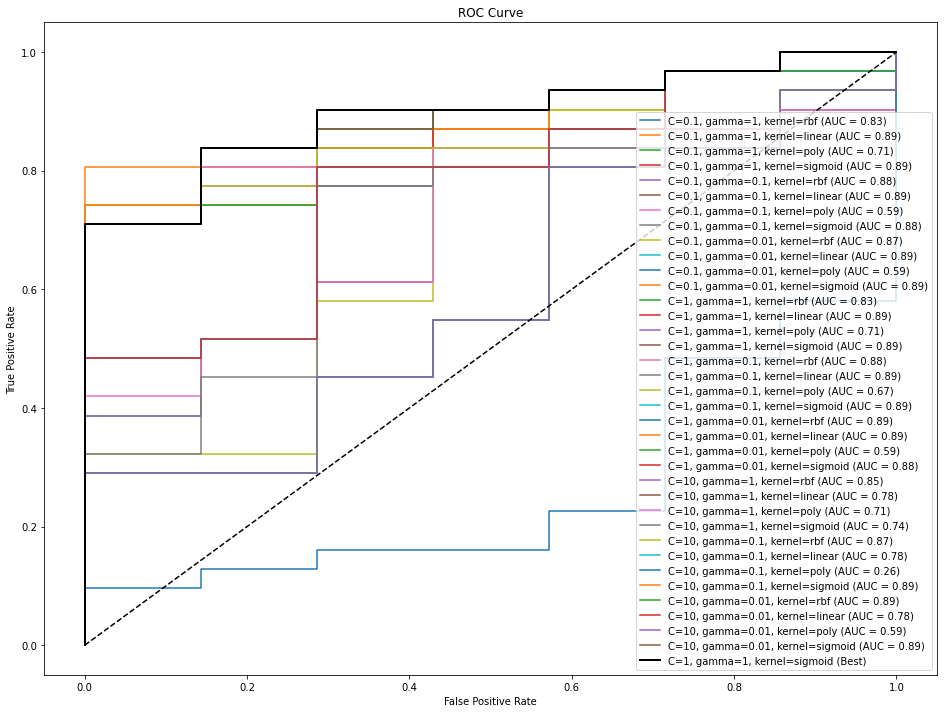

In [92]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm33['C']:
    for gamma in param_svm33['gamma']:
        for kernel in param_svm33['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train33, y_train33)
            y_pred_prob = svm.predict_proba(X_test33)[:, 1]
            fpr, tpr, _ = roc_curve(y_test33, y_pred_prob)
            roc_auc = roc_auc_score(y_test33, y_pred_prob)
            if roc_auc > max_auc:
                max_auc = roc_auc
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm33 = max_auc

**---------Naive Bayes-------------------------**

In [93]:
start = time.time()

scaler = MinMaxScaler()
X_train33nb = scaler.fit_transform(X_train33)
X_test33nb = scaler.transform(X_test33)
param_nb33 = {'alpha': alpha1}

nb33 = MultinomialNB()
grid_cv_nb33 = GridSearchCV(nb33, param_nb33, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train33nb, y_train33.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb33.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train33, grid_cv_nb33.predict(X_train33nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test33, grid_cv_nb33.predict(X_test33nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train33, grid_cv_nb33.predict(X_train33nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test33, grid_cv_nb33.predict(X_test33nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 0.1}
Train accuracy score for Naive Bayes: 1.0
Test accuracy score for Naive Bayes: 0.8157894736842105
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        76

    accuracy                           1.00       111
   macro avg       1.00      1.00      1.00       111
weighted avg       1.00      1.00      1.00       111

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.50      0.86      0.63         7
           1       0.96      0.81      0.88        31

    accuracy                           0.82        38
   macro avg       0.73      0.83      0.75        38
weighted

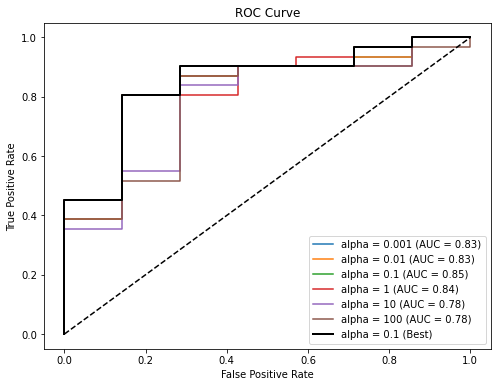

In [94]:
params = params_alpha

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train33nb, y_train33)
    y_prob = nb.predict_proba(X_test33nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test33, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc
    if roc_auc > max_auc:
        max_auc = roc_auc

    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb33 = max_auc

**------------Running Best Parameters---------------**

In [95]:
start = time.time()


svm = SVC(C=grid_cv_svm33.best_params_['C'],
          gamma=grid_cv_svm33.best_params_['gamma'],
          kernel=grid_cv_svm33.best_params_['kernel'])

svm.fit(X_train33, y_train33)
y_test_svm33 = svm.predict(X_test33)

svm_results33 = pd.DataFrame({'True Labels': y_test33.values.ravel(),
                               'Predicted Labels': y_test_svm33})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.03 seconds


In [96]:
start = time.time()



nb = MultinomialNB(alpha=grid_cv_nb33.best_params_['alpha'])
nb.fit(X_train33nb, y_train33)
y_test_nb33 = nb.predict(X_test33nb)

nb_results33 = pd.DataFrame({'True Labels': y_test33.values.ravel(),
                               'Predicted Labels': y_test_nb33})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.01 seconds


**Comparation Performance Result**

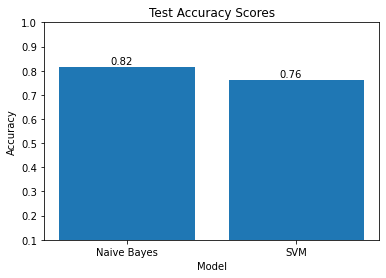

In [97]:
nb_test_acc33 = accuracy_score(y_test33,y_test_nb33)
svm_test_acc33 = accuracy_score(y_test33, y_test_svm33)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc33, svm_test_acc33])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc33 + 0.01, '{:.2f}'.format(nb_test_acc33))
plt.text(0.9, svm_test_acc33 + 0.01, '{:.2f}'.format(svm_test_acc33))
plt.show()


In [98]:
result_svm33 = pd.merge(X_test133[['content']], svm_results33[['Predicted Labels']], left_index=True, right_index=True)
result_nb33 = pd.merge(X_test133[['content']], nb_results33[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [99]:
positive_words = []
negative_words = []
for _, row in result_nb33.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,bantu,2,NaN,NaN
1,aplikasi,1,NaN,NaN
2,oke,1,NaN,NaN
3,sanggat,1,NaN,NaN
4,semoga,1,NaN,NaN
5,grab,1,NaN,NaN
6,nyaman,1,NaN,NaN
7,dep,1,NaN,NaN
8,good,1,NaN,NaN
9,job,1,NaN,NaN


**--------Result From SVM------------**

In [100]:
positive_words = []
negative_words = []
for _, row in result_svm33.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,bantu,2,NaN,NaN
1,aplikasi,1,NaN,NaN
2,oke,1,NaN,NaN
3,sanggat,1,NaN,NaN
4,semoga,1,NaN,NaN
5,grab,1,NaN,NaN
6,nyaman,1,NaN,NaN
7,dep,1,NaN,NaN
8,good,1,NaN,NaN
9,job,1,NaN,NaN


## **3.4 Classification 3.4**

In [101]:
Data34 = pd.read_csv('Data34.csv')
Data34 = Data34.dropna(subset=['content'])
y34 = Data34[['sentiment']]

In [102]:
counter = CountVectorizer()

X = counter.fit_transform(Data34['content'])
vector = pd.DataFrame(X.toarray(), columns = counter.get_feature_names())
vector.set_index(Data34.index,inplace =True)
    
vectorizer = TfidfTransformer()
Y = vectorizer.fit_transform(X)
df_tfidf34 = pd.DataFrame(Y.toarray(), columns = counter.get_feature_names())
df_tfidf34.set_index(Data34.index,inplace =True)
df_tfidf34

,aaplikasi,ada,adminknp,aduh,agak,aj,aja,akhir,aktifitas,aktivitas,...,utk,verifikasi,verivikasi,vermuk,waktu,weeeewww,yaa,yam,yang,yess
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.345749,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.637711,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
X_train34, X_test34, y_train34, y_test34 = train_test_split(df_tfidf34, y34, test_size = datatest, random_state = 546)

In [104]:
X_train134, X_test134, y_train134, y_test134 = train_test_split(Data34, y34, test_size = datatest, random_state = 546)

**---------SVM-------------------------**

In [105]:
start= time.time()
param_svm34 = {'C': cost1,
             'gamma':gamma1,
             'kernel': kernel1
            }

svm = SVC(probability=True)
grid_cv_svm34 = GridSearchCV(svm, param_svm34, scoring="accuracy", n_jobs=-1, cv=None).fit(X_train34, y_train34.values.ravel())

print("Param for SVM", grid_cv_svm34.best_params_)
print("Train Accuracy Score for SVM: ", accuracy_score(y_train34, grid_cv_svm34.predict(X_train34)))
print("Test Accuracy Score for SVM: ", accuracy_score(y_test34, grid_cv_svm34.predict(X_test34)))

print('-' * 80)
print('\nClassification Report Training SVM\n')
print(classification_report(y_train34, grid_cv_svm34.predict(X_train34)))

print('-' * 80)
print('\nClassification Report Testing SVM\n')
print(classification_report(y_test34, grid_cv_svm34.predict(X_test34)))
end = time.time()
print(f"Duration : {end - start} Seconds")

Param for SVM {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy Score for SVM:  1.0
Test Accuracy Score for SVM:  0.868421052631579
--------------------------------------------------------------------------------

Classification Report Training SVM

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        77

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

--------------------------------------------------------------------------------

Classification Report Testing SVM

              precision    recall  f1-score   support

          -1       0.75      0.43      0.55         7
           1       0.88      0.97      0.92        31

    accuracy                           0.87        38
   macro avg       0.82      0.70      0.73        38
weighted avg       0.86    

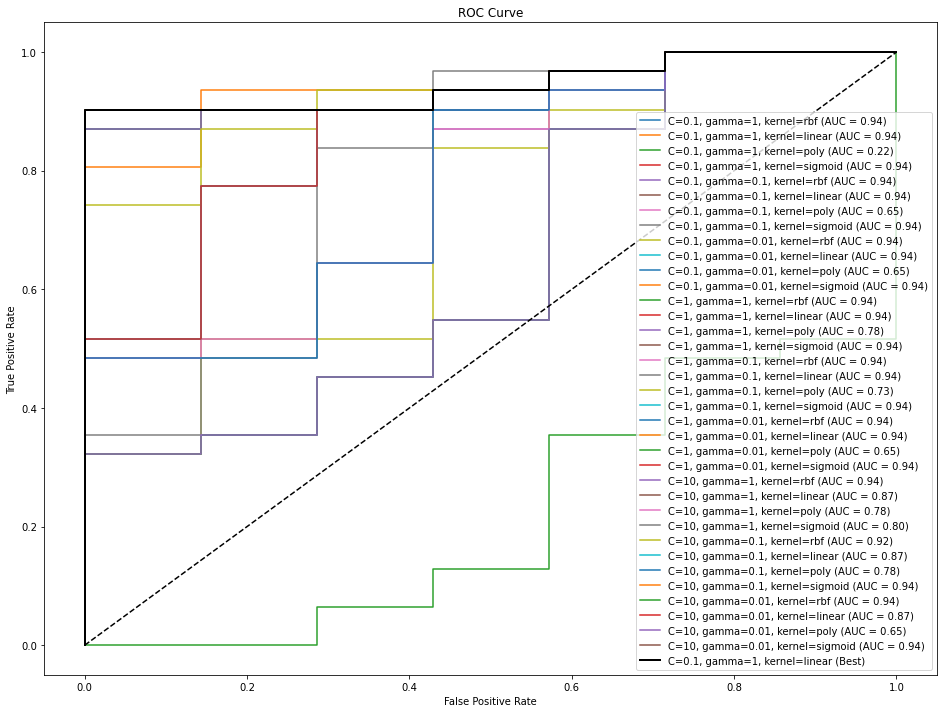

In [106]:
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for C in param_svm34['C']:
    for gamma in param_svm34['gamma']:
        for kernel in param_svm34['kernel']:
            svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
            svm.fit(X_train34, y_train34)
            y_pred_prob = svm.predict_proba(X_test34)[:, 1]
            fpr, tpr, _ = roc_curve(y_test34, y_pred_prob)
            roc_auc = roc_auc_score(y_test34, y_pred_prob)
            if roc_auc > max_auc:
                max_auc = roc_auc
            label = f'C={C}, gamma={gamma}, kernel={kernel}'
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_dict[label] = roc_auc

best_params = max(roc_auc_dict, key=roc_auc_dict.get)

plt.figure(figsize=(16, 12))

for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_svm34 = max_auc

In [107]:
auc_svm34

0.9447004608294931

**---------Naive Bayes-------------------------**

In [108]:
start = time.time()

scaler = MinMaxScaler()
X_train34nb = scaler.fit_transform(X_train34)
X_test34nb = scaler.transform(X_test34)
param_nb34 = {'alpha': alpha1}

nb = MultinomialNB()
grid_cv_nb34 = GridSearchCV(nb, param_nb34, scoring='accuracy', n_jobs=-1, cv=None).fit(X_train34nb, y_train34.values.ravel())

print('Best params for Naive Bayes:', grid_cv_nb34.best_params_)
print('Train accuracy score for Naive Bayes:', accuracy_score(y_train34, grid_cv_nb34.predict(X_train34nb)))
print('Test accuracy score for Naive Bayes:', accuracy_score(y_test34, grid_cv_nb34.predict(X_test34nb)))

print('-' * 80)
print('\nClassification Report Training Naive Bayes\n')
print(classification_report(y_train34, grid_cv_nb34.predict(X_train34nb)))

print('-' * 80)
print('\nClassification Report Testing Naive Bayes\n')
print(classification_report(y_test34, grid_cv_nb34.predict(X_test34nb)))

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Best params for Naive Bayes: {'alpha': 1}
Train accuracy score for Naive Bayes: 0.9910714285714286
Test accuracy score for Naive Bayes: 0.8157894736842105
--------------------------------------------------------------------------------

Classification Report Training Naive Bayes

              precision    recall  f1-score   support

          -1       1.00      0.97      0.99        35
           1       0.99      1.00      0.99        77

    accuracy                           0.99       112
   macro avg       0.99      0.99      0.99       112
weighted avg       0.99      0.99      0.99       112

--------------------------------------------------------------------------------

Classification Report Testing Naive Bayes

              precision    recall  f1-score   support

          -1       0.50      0.71      0.59         7
           1       0.93      0.84      0.88        31

    accuracy                           0.82        38
   macro avg       0.71      0.78      0.73      

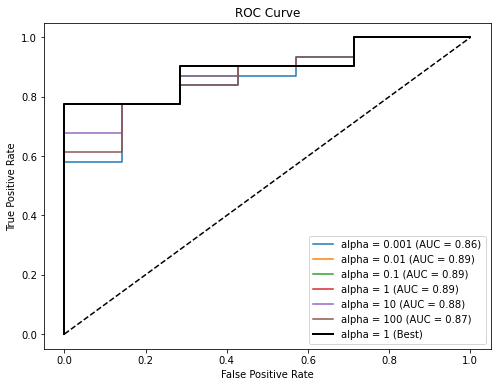

In [109]:
params = params_alpha

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

max_auc = 0.0
for alpha, label in params.items():
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train34nb, y_train34)
    y_prob = nb.predict_proba(X_test34nb)[:, 1]
    fpr, tpr, _ = roc_curve(y_test34, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_dict[label] = fpr
    tpr_dict[label] = tpr
    roc_auc_dict[label] = roc_auc
    if roc_auc > max_auc:
        max_auc = roc_auc

    
best_params = max(roc_auc_dict, key=roc_auc_dict.get)
plt.figure(figsize=(8, 6))
for label, fpr in fpr_dict.items():
    plt.plot(fpr, tpr_dict[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
plt.plot(fpr_dict[best_params], tpr_dict[best_params], 'k-', linewidth=2, label=f'{best_params} (Best)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc_nb34 = max_auc

**------------Running Best Parameters---------------**

In [110]:
start = time.time()


svm = SVC(C=grid_cv_svm34.best_params_['C'],
          gamma=grid_cv_svm34.best_params_['gamma'],
          kernel=grid_cv_svm34.best_params_['kernel'])

svm.fit(X_train34, y_train34)
y_test_svm34 = svm.predict(X_test34)

svm_results34 = pd.DataFrame({'True Labels': y_test34.values.ravel(),
                               'Predicted Labels': y_test_svm34})

end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.03 seconds


In [111]:
start = time.time()



nb = MultinomialNB(alpha=grid_cv_nb34.best_params_['alpha'])
nb.fit(X_train34nb, y_train34)
y_test_nb34 = nb.predict(X_test34nb)

nb_results34 = pd.DataFrame({'True Labels': y_test34.values.ravel(),
                               'Predicted Labels': y_test_nb34})


end = time.time()
print(f"Duration: {end - start:.2f} seconds")

Duration: 0.01 seconds


**Comparation Performance Result**

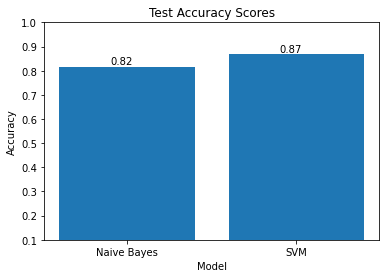

In [112]:
nb_test_acc34 = accuracy_score(y_test34,y_test_nb34)
svm_test_acc34 = accuracy_score(y_test34, y_test_svm34)


plt.show()
plt.bar(['Naive Bayes', 'SVM'], [nb_test_acc34, svm_test_acc34])
plt.ylim(0.1, 1.0)
plt.title('Test Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.text(-0.1, nb_test_acc34 + 0.01, '{:.2f}'.format(nb_test_acc34))
plt.text(0.9, svm_test_acc34 + 0.01, '{:.2f}'.format(svm_test_acc34))
plt.show()


In [113]:
result_svm34 = pd.merge(X_test134[['content']], svm_results34[['Predicted Labels']], left_index=True, right_index=True)
result_nb34 = pd.merge(X_test134[['content']], nb_results34[['Predicted Labels']], left_index=True, right_index=True)

**--------Result from Naive Bayes----------**

In [114]:
positive_words = []
negative_words = []
for _, row in result_nb34.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,luar,1,oke,1.0
1,biasa,1,sanggat,1.0
2,karena,1,NaN,NaN
3,semoga,1,NaN,NaN
4,saja,1,NaN,NaN
5,lebih,1,NaN,NaN
6,baik,1,NaN,NaN
7,nyaman,1,NaN,NaN
8,dep,1,NaN,NaN
9,good,1,NaN,NaN


**--------Result From SVM------------**

In [115]:
positive_words = []
negative_words = []
for _, row in result_svm34.iterrows():
    words = row['content'].split()
    if row['Predicted Labels'] == 1:
        positive_words.extend(words)
    else:
        negative_words.extend(words)

positive_word_count = pd.Series(positive_words).value_counts()
positive_df = pd.DataFrame({'positive_word': positive_word_count.index[:10],
                            'positive_frequency': positive_word_count.values[:10]})

negative_word_count = pd.Series(negative_words).value_counts()
negative_df = pd.DataFrame({'negative_word': negative_word_count.index[:10],
                            'negative_frequency': negative_word_count.values[:10]})

result_df = pd.concat([positive_df, negative_df], axis=1)
result_df

,positive_word,positive_frequency,negative_word,negative_frequency
0,luar,1,oke,1.0
1,biasa,1,sanggat,1.0
2,karena,1,NaN,NaN
3,semoga,1,NaN,NaN
4,saja,1,NaN,NaN
5,lebih,1,NaN,NaN
6,baik,1,NaN,NaN
7,nyaman,1,NaN,NaN
8,dep,1,NaN,NaN
9,good,1,NaN,NaN


# **4. Conclussion**

## **4.1 Conclussion by The Performance**

**-----By The Accuracy--------**

In [116]:
df_con = pd.DataFrame({
    'method': ['svm', 'svm', 'svm', 'svm',
               'nb', 'nb', 'nb', 'nb',
               'svm', 'svm', 'svm', 'svm',
               'nb', 'nb', 'nb', 'nb'],  
    'Sampling': ['Balanced', 'Balanced', 'Balanced', 'Balanced',
               'Balanced', 'Balanced', 'Balanced', 'Balanced',
               'UnBalanced', 'UnBalanced', 'UnBalanced', 'UnBalanced',
               'UnBalanced', 'UnBalanced', 'UnBalanced', 'UnBalanced'],
    'Preproces Method': ['NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs',
                         'NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs',
                         'NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs',
                         'NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs'],
    'variable_name': ['kmeans_silhouette_21', 'kmeans_silhouette_22', 'kmeans_silhouette_23', 'kmeans_silhouette_24',
                      'dbscan_silhouette_21', 'dbscan_silhouette_22', 'dbscan_silhouette_23', 'dbscan_silhouette_24',
                      'kmeans_silhouette_31', 'kmeans_silhouette_32', 'kmeans_silhouette_33', 'kmeans_silhouette_34',
                      'dbscan_silhouette_31', 'dbscan_silhouette_32', 'dbscan_silhouette_33', 'dbscan_silhouette_34'],
    'accuracy': [svm_test_acc21, svm_test_acc22, svm_test_acc23, svm_test_acc24,
                      nb_test_acc21, nb_test_acc22, nb_test_acc23, nb_test_acc24,
                      svm_test_acc31, svm_test_acc32, svm_test_acc33, svm_test_acc34,
                      nb_test_acc31, nb_test_acc32, nb_test_acc33, nb_test_acc34]
})

df_con

,method,Sampling,Preproces Method,variable_name,accuracy
0,svm,Balanced,NA & Classic,kmeans_silhouette_21,0.526316
1,svm,Balanced,NA & Zipfs,kmeans_silhouette_22,0.631579
2,svm,Balanced,Porter & Classic,kmeans_silhouette_23,0.578947
3,svm,Balanced,Porter & Zipfs,kmeans_silhouette_24,0.605263
4,nb,Balanced,NA & Classic,dbscan_silhouette_21,0.578947
5,nb,Balanced,NA & Zipfs,dbscan_silhouette_22,0.552632
6,nb,Balanced,Porter & Classic,dbscan_silhouette_23,0.578947
7,nb,Balanced,Porter & Zipfs,dbscan_silhouette_24,0.552632
8,svm,UnBalanced,NA & Classic,kmeans_silhouette_31,0.736842
9,svm,UnBalanced,NA & Zipfs,kmeans_silhouette_32,0.842105


In [117]:
pivot_ui(df_con)

**------------By The AUC------------**

In [118]:
df_auc = pd.DataFrame({
    'method': ['svm', 'svm', 'svm', 'svm',
               'nb', 'nb', 'nb', 'nb',
               'svm', 'svm', 'svm', 'svm',
               'nb', 'nb', 'nb', 'nb'],  
    'Sampling': ['Balanced', 'Balanced', 'Balanced', 'Balanced',
               'Balanced', 'Balanced', 'Balanced', 'Balanced',
               'UnBalanced', 'UnBalanced', 'UnBalanced', 'UnBalanced',
               'UnBalanced', 'UnBalanced', 'UnBalanced', 'UnBalanced'],
    'Preproces Method': ['NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs',
                         'NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs',
                         'NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs',
                         'NA & Classic', 'NA & Zipfs', 'Porter & Classic', 'Porter & Zipfs'],
    'variable_name': ['kmeans_silhouette_21', 'kmeans_silhouette_22', 'kmeans_silhouette_23', 'kmeans_silhouette_24',
                      'dbscan_silhouette_21', 'dbscan_silhouette_22', 'dbscan_silhouette_23', 'dbscan_silhouette_24',
                      'kmeans_silhouette_31', 'kmeans_silhouette_32', 'kmeans_silhouette_33', 'kmeans_silhouette_34',
                      'dbscan_silhouette_31', 'dbscan_silhouette_32', 'dbscan_silhouette_33', 'dbscan_silhouette_34'],
    'auc': [auc_svm21, auc_svm22, auc_svm23, auc_svm24,
                      auc_nb21, auc_nb22, auc_nb23, auc_nb24,
                      auc_svm31, auc_svm32, auc_svm33, auc_svm34,
                      auc_nb31, auc_nb32, auc_nb33, auc_nb34]
    })

df_auc

,method,Sampling,Preproces Method,variable_name,auc
0,svm,Balanced,NA & Classic,kmeans_silhouette_21,0.572222
1,svm,Balanced,NA & Zipfs,kmeans_silhouette_22,0.643056
2,svm,Balanced,Porter & Classic,kmeans_silhouette_23,0.669444
3,svm,Balanced,Porter & Zipfs,kmeans_silhouette_24,0.651389
4,nb,Balanced,NA & Classic,dbscan_silhouette_21,0.655556
5,nb,Balanced,NA & Zipfs,dbscan_silhouette_22,0.691667
6,nb,Balanced,Porter & Classic,dbscan_silhouette_23,0.697222
7,nb,Balanced,Porter & Zipfs,dbscan_silhouette_24,0.697222
8,svm,UnBalanced,NA & Classic,kmeans_silhouette_31,0.903226
9,svm,UnBalanced,NA & Zipfs,kmeans_silhouette_32,0.944700


In [119]:
pivot_ui(df_auc)

# **4.2 Conclussion by The Result**

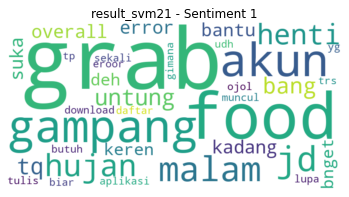

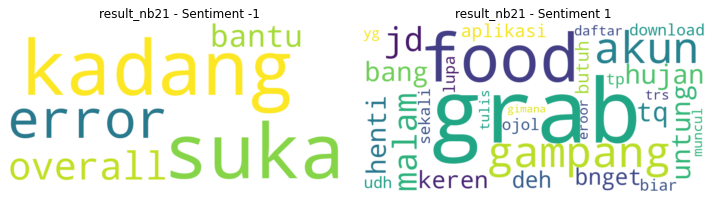

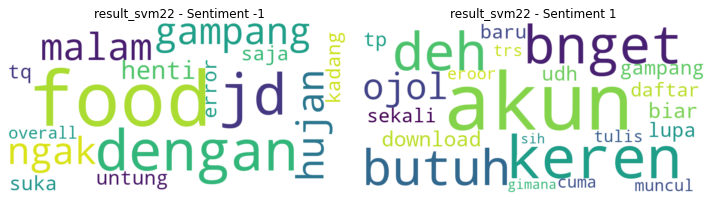

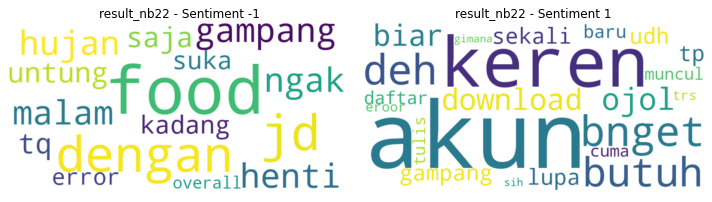

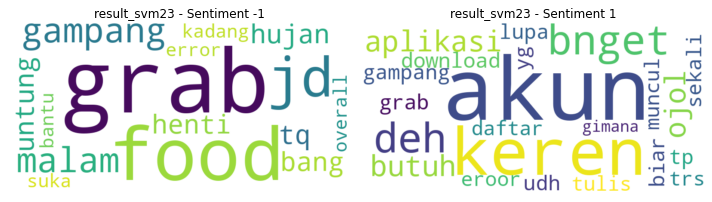

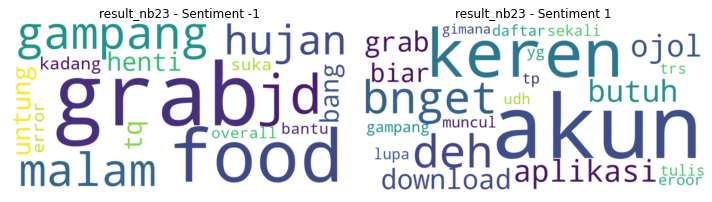

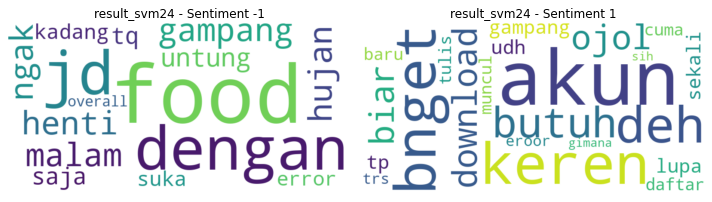

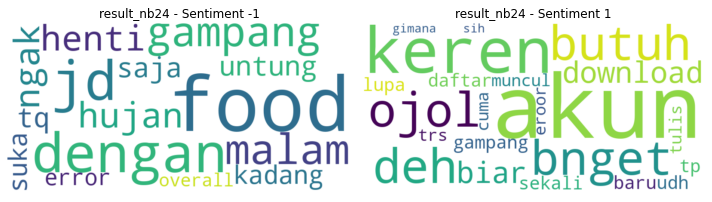

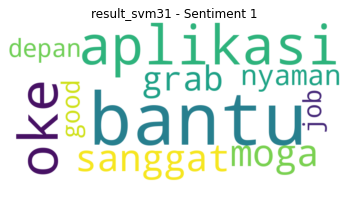

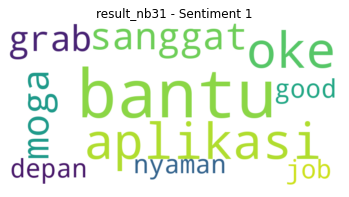

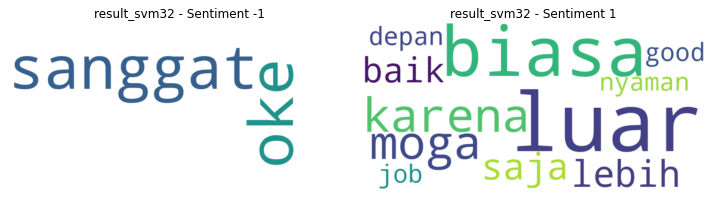

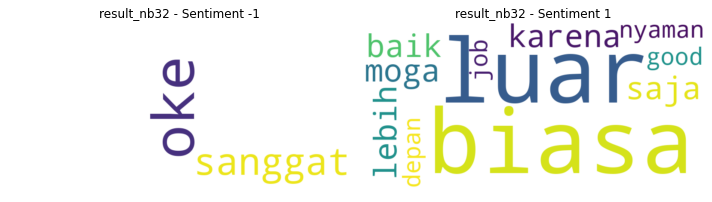

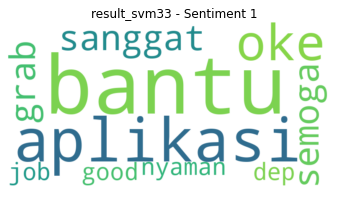

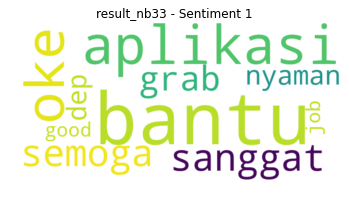

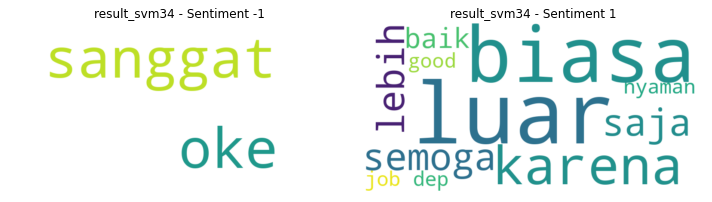

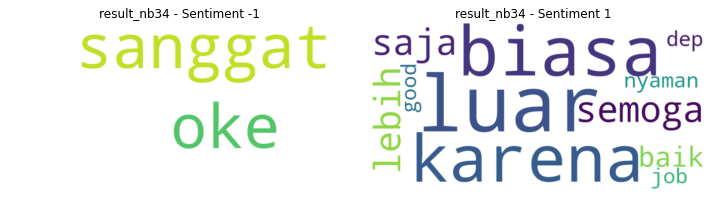

In [120]:
dataframes = ['result_svm21', 'result_nb21', 'result_svm22', 'result_nb22', 'result_svm23',
              'result_nb23', 'result_svm24', 'result_nb24', 'result_svm31', 'result_nb31',
              'result_svm32', 'result_nb32', 'result_svm33', 'result_nb33', 'result_svm34',
              'result_nb34']

for df_name in dataframes:
    df = globals()[df_name]

    unique_sentiments = df['Predicted Labels'].unique()
    
    if len(unique_sentiments) == 1:
        sentiment = unique_sentiments[0]

        text = ' '.join(df['content'].tolist())

        wordcloud = WordCloud(width=800, height=400,background_color="white").generate(text)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{df_name} - Sentiment {sentiment}')
        plt.axis('off')
        plt.show()
        
    elif len(unique_sentiments) == -1:
        sentiment = unique_sentiments[0]

        text = ' '.join(df['content'].tolist())

        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{df_name} - Sentiment {sentiment}')
        plt.axis('off')
        plt.show()

    else:
        df_neg = df[df['Predicted Labels'] == -1]
        df_pos = df[df['Predicted Labels'] == 1]

        neg_text = ' '.join(df_neg['content'].tolist())

        pos_text = ' '.join(df_pos['content'].tolist())

        wordcloud_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text)
        wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(wordcloud_neg, interpolation='bilinear')
        axes[0].set_title(f'{df_name} - Sentiment -1')
        axes[0].axis('off')

        axes[1].imshow(wordcloud_pos, interpolation='bilinear')
        axes[1].set_title(f'{df_name} - Sentiment 1')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()